In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load data
df = pd.read_csv('data.csv')
print(df.shape)
df.head()


(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Target engineering (Malignant=1, Benign=0)
y = (df['diagnosis'] == 'M').astype(int)
X = df.drop(columns=['id','diagnosis'])
feature_names_full = X.columns.tolist()
print('Initial features:', len(feature_names_full))
X.head()


Initial features: 30


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# Train/Test split BEFORE any fitting (prevents leakage)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(X_train_full.shape, X_test_full.shape)


(455, 30) (114, 30)


# FEATURE SELECTION METHOD = CORRELATION MATRIX

In [6]:
# Correlation-based feature selection using only training data
train_df = X_train_full.copy()
train_df['Target'] = y_train.values
corr = train_df.corr(numeric_only=True)
threshold = 0.30  # can adjust
selected_features = [
    col for col in corr.columns
    if col != 'Target' and abs(corr.loc[col,'Target']) >= threshold
]
print('Selected (abs corr >=', threshold, '):', len(selected_features))
print(selected_features)


Selected (abs corr >= 0.3 ): 23
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'concave points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [9]:
# Fallback if threshold was too strict
if len(selected_features) == 0:
    selected_features = feature_names_full  # keep all
    print('No features passed threshold; using all.')

X_train = X_train_full[selected_features].copy()  # ← HERE
X_test = X_test_full[selected_features].copy()    # ← HERE
print('Final feature count:', X_train.shape[1])


Final feature count: 23


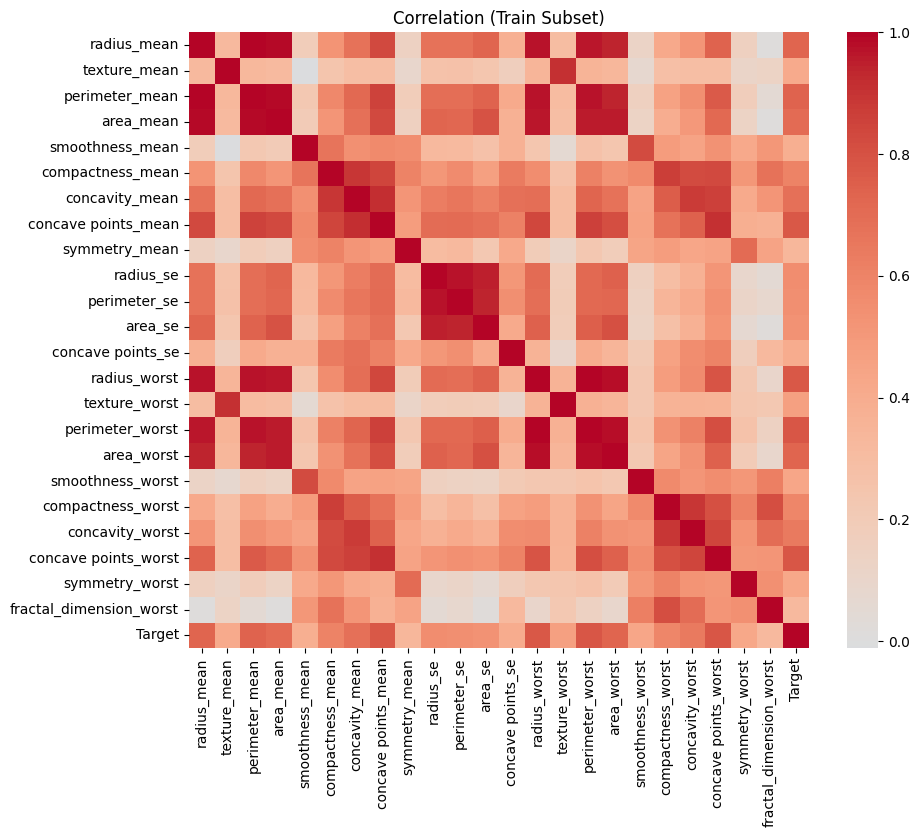

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df[selected_features + ['Target']].corr(), cmap='coolwarm', center=0)
plt.title('Correlation (Train Subset)')
plt.show()


In [11]:
def evaluate_model(name, model, Xtr, Xte, ytr, yte):
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)
    return {
        'model': name,
        'train_acc': accuracy_score(ytr, ytr_pred),
        'test_acc': accuracy_score(yte, yte_pred)
    }


In [12]:
# SVM Pipeline with GridSearch (Scaling included)
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

svm_param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10, 100], 'svc__probability':[True]},
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10, 100], 'svc__gamma': ['scale','auto'], 'svc__probability':[True]}
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_grid = GridSearchCV(
    svm_pipe, svm_param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0
)
svm_grid.fit(X_train, y_train)
print('Best SVM Params:', svm_grid.best_params_)
print('Best CV Accuracy:', round(svm_grid.best_score_,4))
best_svm = svm_grid.best_estimator_


Best SVM Params: {'svc__C': 0.1, 'svc__kernel': 'linear', 'svc__probability': True}
Best CV Accuracy: 0.9714


In [13]:
# Logistic Regression (simple tuned grid)
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=500, random_state=42))
])
lr_params = {
    'lr__C': [0.1,1,10],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs']
}
lr_grid = GridSearchCV(lr_pipe, lr_params, scoring='accuracy', cv=cv, n_jobs=-1)
lr_grid.fit(X_train, y_train)
print('Best LR Params:', lr_grid.best_params_)
best_lr = lr_grid.best_estimator_


Best LR Params: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


In [14]:
# Decision Tree (light tuning)
dt_pipe = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])
dt_params = {
    'dt__max_depth': [None, 3, 5, 7, 9],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(dt_pipe, dt_params, scoring='accuracy', cv=cv, n_jobs=-1)
dt_grid.fit(X_train, y_train)
print('Best DT Params:', dt_grid.best_params_)
best_dt = dt_grid.best_estimator_


Best DT Params: {'dt__max_depth': 7, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}


In [15]:
# Random Forest (restricted tuning to keep runtime reasonable)
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
rf_params = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, scoring='accuracy', cv=cv, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print('Best RF Params:', rf_grid.best_params_)
best_rf = rf_grid.best_estimator_


Best RF Params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


In [16]:
# Aggregate performance
results = []
for name, mdl in [
    ('SVM', best_svm),
    ('LogReg', best_lr),
    ('DecisionTree', best_dt),
    ('RandomForest', best_rf)
]:
    res = evaluate_model(name, mdl, X_train, X_test, y_train, y_test)
    results.append(res)
pd.DataFrame(results)


,model,train_acc,test_acc
0,SVM,0.980220,0.991228
1,LogReg,0.978022,0.982456
2,DecisionTree,0.986813,0.929825
3,RandomForest,0.993407,0.964912


Chosen final model: SVM

Classification Report (Test):
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99        72
   Malignant       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



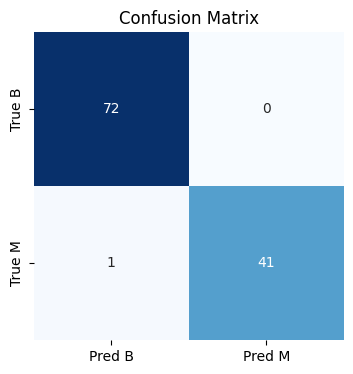

In [ ]:
results_sorted = sorted(results, key=lambda d: d['test_acc'], reverse=True)
best_name = results_sorted[0]['model']
print('Chosen final model:', best_name)

model_map = {
    'SVM': best_svm,
    'LogReg': best_lr,
    'DecisionTree': best_dt,
    'RandomForest': best_rf
}
final_pipeline = model_map[best_name]

# Evaluate in detail
y_pred = final_pipeline.predict(X_test)
print('\nClassification Report (Test):')
print(classification_report(y_test, y_pred, target_names=['Benign','Malignant']))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred B','Pred M'], yticklabels=['True B','True M'])
plt.title('Confusion Matrix')
plt.show()


In [18]:
svm_classifier = final_pipeline  # Keeping variable name as requested

# Save EXACTLY as before (pickle, same filename)
filename = 'breastCancer.sav'
with open(filename, 'wb') as f:
    pickle.dump(svm_classifier, f)
print('Saved model to', filename)


Saved model to breastCancer.sav


In [19]:
meta = {
  'model_file': 'breastCancer.sav',
  'final_model_type': best_name,
  'selected_features': selected_features,
  'all_features_original_order': feature_names_full,
  'best_params': (svm_classifier.named_steps['svc'].get_params() if best_name=='SVM' else None),
  'target_mapping': {'0':'Benign','1':'Malignant'},
  'positive_class': 1
}
with open('breastCancer_metadata.json','w') as f:
    json.dump(meta, f, indent=2)
print('Metadata saved: breastCancer_metadata.json')


Metadata saved: breastCancer_metadata.json
